In [1]:
import os
import re
import analyse
import numpy as np
import Bio.PDB as biop
import MDAnalysis as mda
import MDAnalysis.analysis.rms as rms
import MDAnalysis.analysis.helanal as helanal
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
PDB_CODE = '6b73'
SEQ = '_B'
# folder_name = PDB_CODE+SEQ'

folder = '../1/'
# it should be the folder which contains all the initial parameters and the simultaion results
# name should be 'charmm-gui-'+folder pl: charmm-gui-6b73B
# later this folder should be copied from cluster containig the NAMD results

charmm_folder = folder+'charmm-gui-'+PDB_CODE+SEQ
print(charmm_folder)
charmm_folder = folder+'results'

../1/charmm-gui-6b73_B


In [3]:
trajectories = []
dcd_files = sorted([charmm_folder+'/namd/'+i for i in os.listdir(charmm_folder+'/namd/') if re.match(r'(step6.).*\_equilibration.dcd$', i)])
for i in range(6):
    u = mda.Universe(charmm_folder+'/step5_assembly.xplor_ext.psf', dcd_files[i])
    trajectories.append(u)

## Root mean square deviation:

Text(0.5, 0, 'Equilibration step')

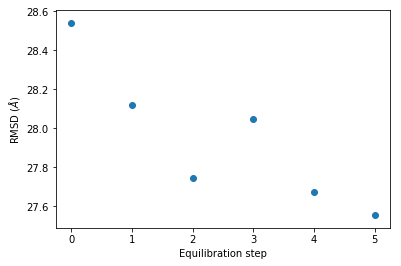

In [4]:
rmsds = []
for i in range(len(trajectories)):
    first_frame = trajectories[i].select_atoms('name CA').positions[0]
    last_frame = trajectories[i].select_atoms('name CA').positions[-1]
    rmsds.append(rms.rmsd(last_frame, first_frame))
plt.scatter(range(len(trajectories)), rmsds)
plt.ylabel('RMSD ($\AA$)')
plt.xlabel('Equilibration step')

### RMSD of backbone over time:

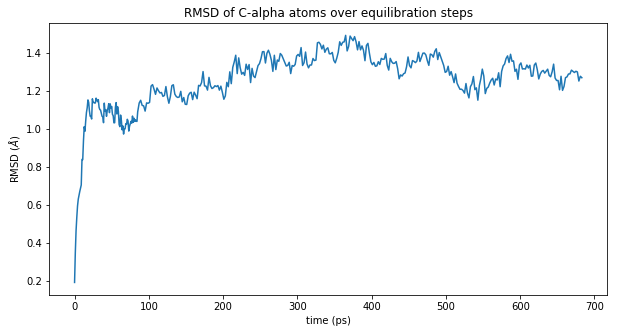

array([[0.00000000e+00, 1.00000000e+00, 2.00000000e+00, ...,
        3.82000000e+02, 3.83000000e+02, 3.84000000e+02],
       [0.00000000e+00, 1.00000000e+00, 2.00000001e+00, ...,
        6.79000002e+02, 6.81000002e+02, 6.83000002e+02],
       [1.93254259e-01, 3.47936498e-01, 4.63184291e-01, ...,
        1.25054321e+00, 1.27564075e+00, 1.26792130e+00]])

In [5]:
all_traj = mda.Universe(charmm_folder+'/step5_assembly.xplor_ext.psf', dcd_files)    
ref = mda.Universe(folder+'6b73_fin.pdb')
analyse.rmsd_traj(all_traj, ref, plot=True)

## Root mean square fluctuation:

In [6]:
pdb_file = folder+'6b73_fin.pdb'
struct = analyse.secondary_structure(pdb_file)

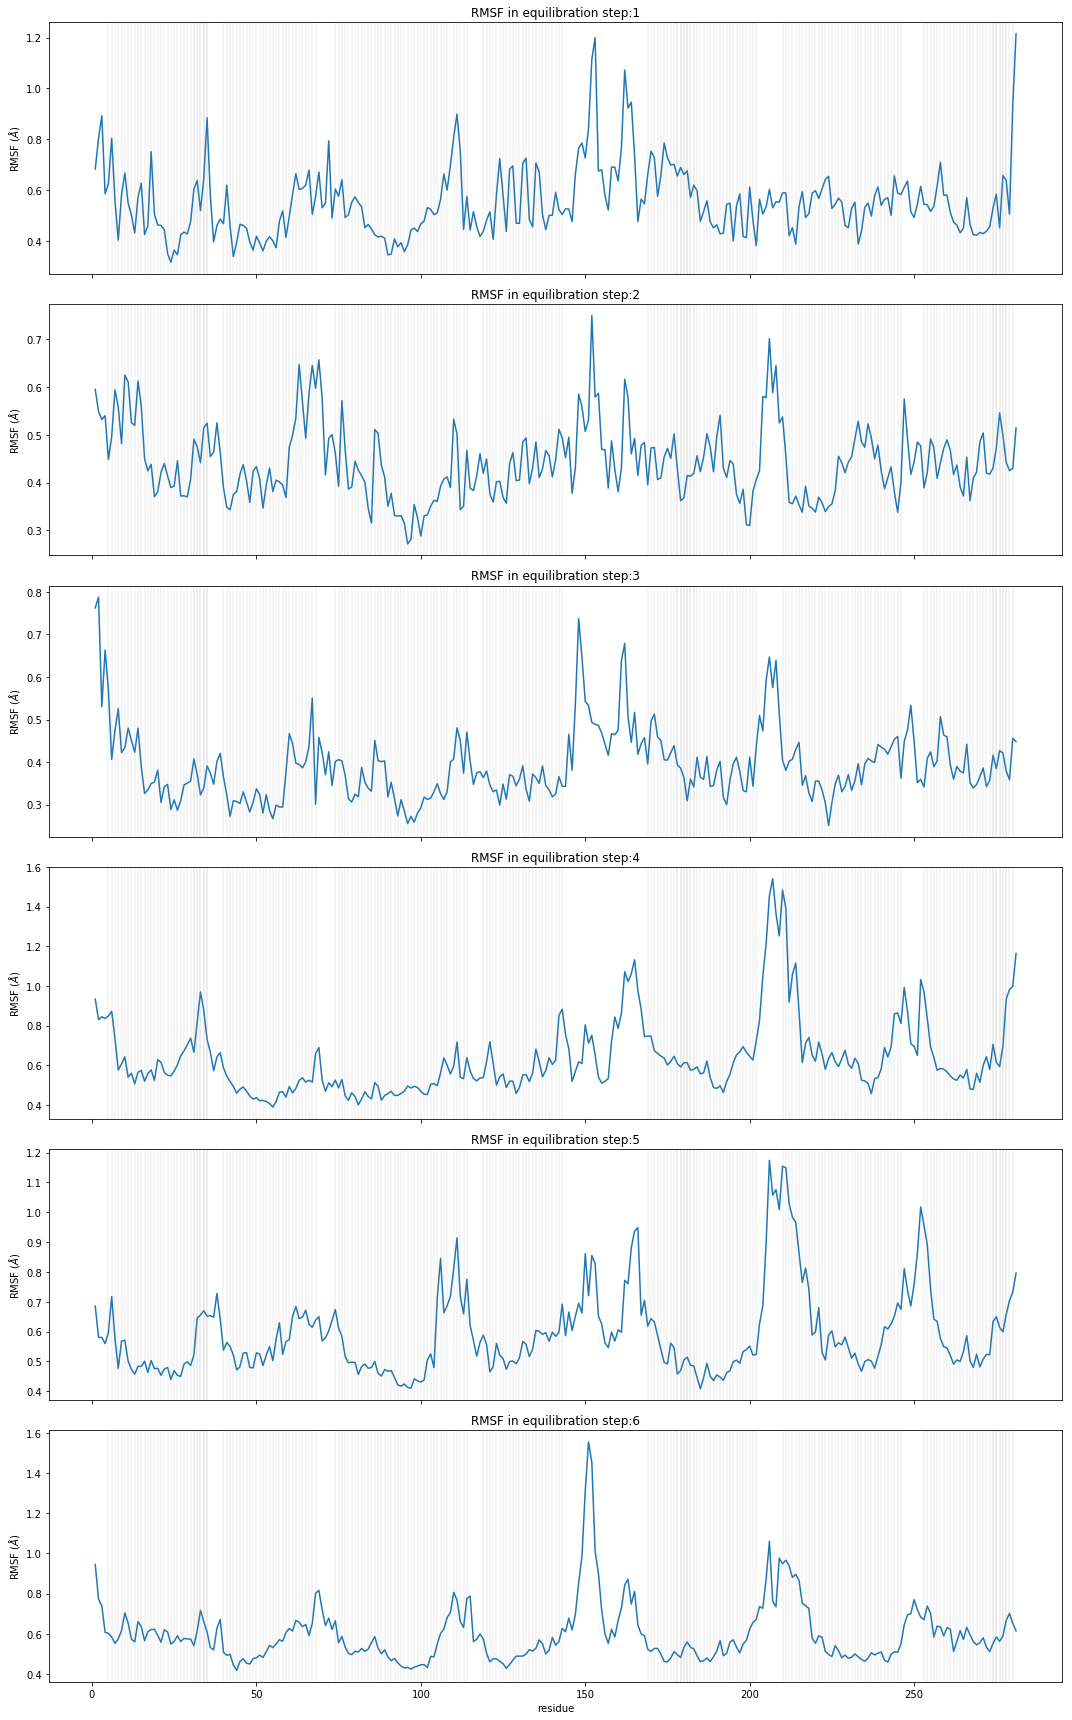

In [10]:
analyse.rmsf_plot(trajectories, title='RMSF in equilibration step:{}', structure=struct)

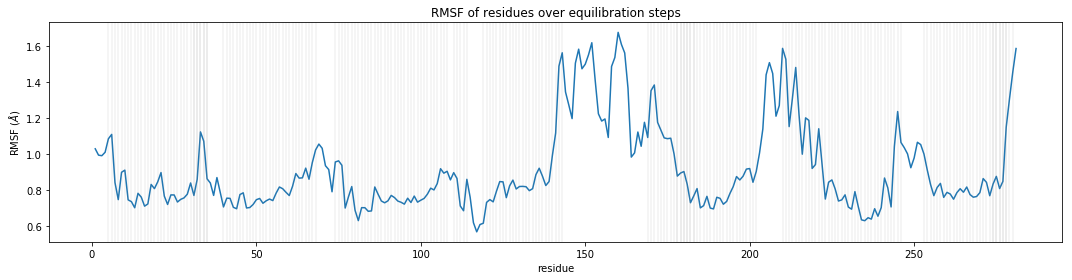

In [9]:
analyse.rmsf_plot([all_traj], title='RMSF of residues over equilibration steps', structure=struct)